In [1]:
### PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio

# Step 1: Import modules and define constants
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [2]:
# Step 2: Data retrieval and Visualisation
def download_data():
    # name of stock as key, stock values 2010-2023
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [3]:
# Step 3: Returns calculation and Portfolio Statistics
# To calculate return using normalisation, show statistics using annual metrics
def calculate_return(data):
    # Normalization - to measure variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]                    # Don't need first row of dataset, since values are NaN

def show_statistics(returns):
    # Instead of daily metrics, use annual metrics
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS
    print("Annual Mean Returns:")
    print(annual_mean)
    print("Annual Covariance Matrix:")
    print(annual_covariance)

In [4]:
# Step 4: To visaulise efficient frontier and displau portfolio metrics
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


# Generate multiple portfolios: Display their efficient frontier
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [5]:
# Step 5: Portfolio Generation
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # Generate random weight
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_mean = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_risk = np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w)))
        portfolio_means.append(portfolio_mean)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [6]:
# Step 6: Portfolio Optimization Functions
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Scipy optimize module can find the minimum of a given function
# Maximum of f(x) is minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Constraints: Sum of weights = 1
# f(x) = 0 this is the function to minimize
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Weights can be 1 at most: 1 when 100% of money invested in single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)


In [7]:
# Step 7: Portfolio Results Presentation
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio weights:", optimum['x'].round(3))
    expected_return, volatility, sharpe_ratio = statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {expected_return}")
    print(f"Expected volatility (standard deviation): {volatility}")
    print(f"Sharpe ratio: {sharpe_ratio}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

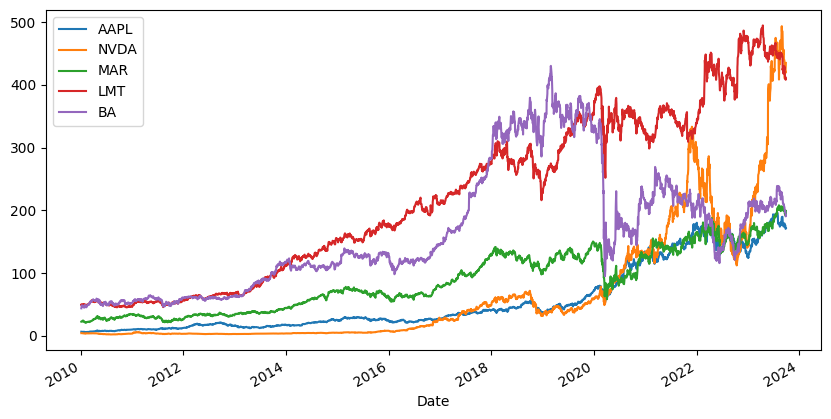



Annual Mean Returns:
AAPL    0.238519
NVDA    0.337450
MAR     0.157839
LMT     0.153483
BA      0.107614
dtype: float64
Annual Covariance Matrix:
          AAPL      NVDA       MAR       LMT        BA
AAPL  0.080627  0.064419  0.036103  0.021053  0.041491
NVDA  0.064419  0.200282  0.054602  0.025807  0.060011
MAR   0.036103  0.054602  0.098672  0.022343  0.065004
LMT   0.021053  0.025807  0.022343  0.044809  0.036176
BA    0.041491  0.060011  0.065004  0.036176  0.130475




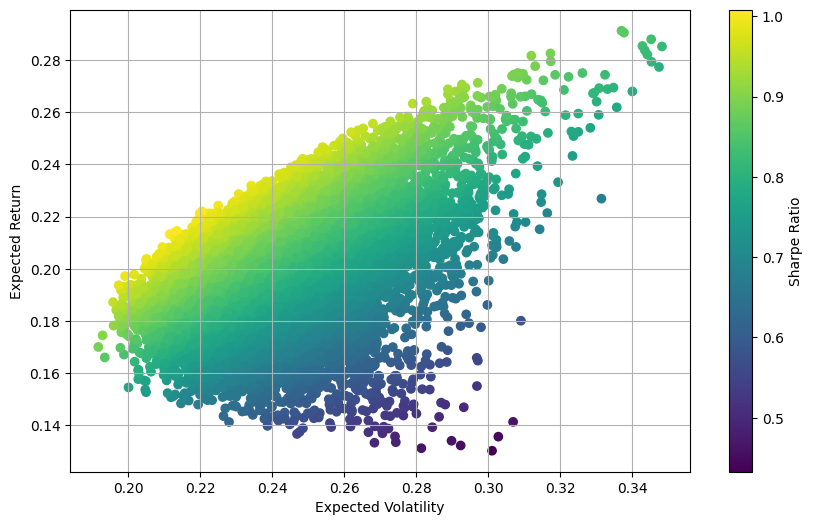



Optimal portfolio weights: [0.364 0.182 0.004 0.45  0.   ]
Expected return: 0.21793546711099768
Expected volatility (standard deviation): 0.21521347616634431
Sharpe ratio: 1.0126478647765973


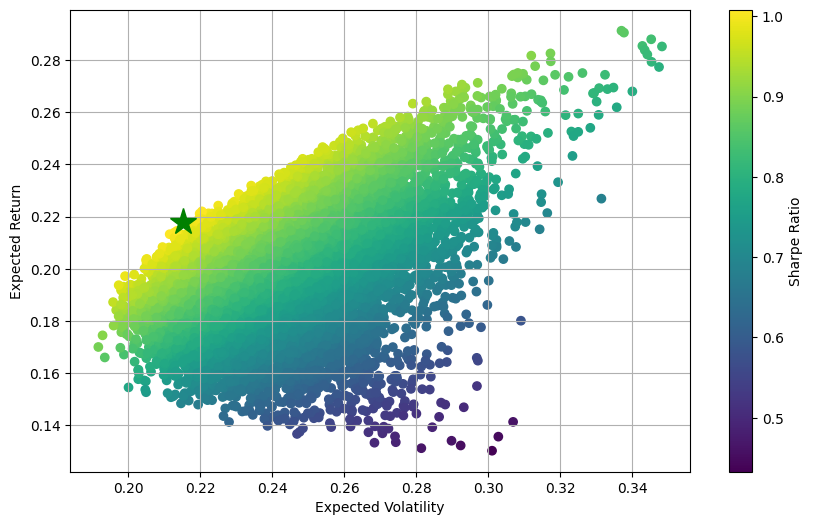

In [8]:
# Main Workflow
# First output: Display stock prices of the 5 stocks, using yfinance
dataset = download_data()
show_data(dataset)
print('\n')

# Second output: Annual Mean returns and covariance matrix of stocks in portfolio
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)
print('\n')

# Third output: Display Scatterplot of expected return against expected volatility, color coded by sharpe ratio
weights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
print('\n')

# Fourth output: Display most optimal portfolio (highest sharpe ratio), denoted by green star
# Each value in the list for optimal portfolio shows the corresponding optimal percentage each stock should take in portfolio
optimum = optimize_portfolio(weights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [9]:
### PART 2: Analysing of the 5 stock prices, with incorporation of their corresponding sentiment score (extracted using NLP and FinBert)
### NOTE: Wil not be forecasting prices because there are measured in absolute terms and thus harder to compare across time and other assets.
###       Hence, will be forecasting daily returns instead

# Step 1: Import modules and load data
import yfinance as yf
import math
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']
stock_data = yf.download(stocks, start='2010-01-01', end='2023-10-20', group_by='tickers')
stock_data.head()

[*********************100%%**********************]  5 of 5 completed


NVDA                                                 AAPL  \
              Open   High     Low   Close Adj Close    Volume      Open   
Date                                                                      
2010-01-04  4.6275  4.655  4.5275  4.6225  4.240800  80020400  7.622500   
2010-01-05  4.6050  4.740  4.6050  4.6900  4.302728  72864800  7.664286   
2010-01-06  4.6875  4.730  4.6425  4.7200  4.330249  64916800  7.656429   
2010-01-07  4.6950  4.715  4.5925  4.6275  4.245387  54779200  7.562500   
2010-01-08  4.5900  4.670  4.5625  4.6375  4.254562  47816800  7.510714   

                                          ...        MAR             \
                High       Low     Close  ...        Low      Close   
Date                                      ...                         
2010-01-04  7.660714  7.585000  7.643214  ...  25.636192  26.041470   
2010-01-05  7.699643  7.616071  7.656429  ...  25.796417  26.192270   
2010-01-06  7.686786  7.526786  7.534643  ...  25.947220  26.267672   
2010-01-07  7.571429  7.466071  7.520714  ...  26.107447  26.371347   
2010-01-08  7.571429  7.466429  7.570714  ...  26.163996  26.427898   

                                       BA                                   \
            Adj Close   Volume       Open       High        Low      Close   
Date                                                                         
2010-01-04  22.534813  2860350  55.720001  56.389999  54.799999  56.180000   
2010-01-05  22.665297  2627885  56.250000  58.279999  56.000000  58.020000   
2010-01-06  22.730553  2789900  58.230000  59.990002  57.880001  59.779999   
2010-01-07  22.820261  2560724  59.509998  62.310001  59.020000  62.200001   
2010-01-08  22.869202  3961031  61.540001  61.779999  60.860001  61.599998   

                                 
            Adj Close    Volume  
Date                             
2010-01-04  43.777554   6186700  
2010-01-05  45.211353   8867800  
2010-01-06  46.582794   8836500  
2010-01-07  48.468559  14379100  
2010-01-08  48.001011   7146600  

[5 rows x 30 columns]

In [10]:
# Step 2: Clean and explore data
stock_data.describe()

NVDA                                                      \
              Open         High          Low        Close    Adj Close   
count  3473.000000  3473.000000  3473.000000  3473.000000  3473.000000   
mean     67.350733    68.593902    66.066085    67.381228    67.105124   
std      98.896408   100.733723    96.943027    98.886316    98.920439   
min       2.180000     2.262500     2.162500     2.220000     2.036686   
25%       4.182500     4.250000     4.107500     4.185000     3.839427   
50%      23.025000    23.152500    22.512501    22.955000    22.627161   
75%      78.074997    79.080002    75.947502    78.025002    77.774628   
max     502.160004   502.660004   489.579987   493.549988   493.509338   

                            AAPL                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.473000e+03  3473.000000  3473.000000  3473.000000  3473.000000  ...   
mean   5.068752e+07    58.096316    58.731987    57.488376    58.135312  ...   
std    3.143003e+07    53.667291    54.301794    53.084844    53.719198  ...   
min    4.564400e+06     6.870357     7.000000     6.794643     6.858929  ...   
25%    3.074880e+07    19.500000    19.660000    19.245001    19.445356  ...   
50%    4.351480e+07    31.990000    32.220001    31.719999    31.950001  ...   
75%    6.167640e+07    79.665001    80.587502    79.125000    79.750000  ...   
max    3.692928e+08   196.240005   198.229996   195.279999   196.449997  ...   

               MAR                                                   BA  \
               Low        Close    Adj Close        Volume         Open   
count  3473.000000  3473.000000  3473.000000  3.473000e+03  3473.000000   
mean     90.708125    91.821133    88.078616  2.855895e+06   173.790193   
std      47.958425    48.564686    49.435964  1.881032e+06    94.181145   
min      24.024506    24.260132    20.993336  4.452000e+05    55.720001   
25%      40.970001    41.389999    37.193226  1.715800e+06   100.250000   
50%      80.059998    81.000000    75.676697  2.337100e+06   145.960007   
75%     133.490005   135.050003   131.097122  3.418700e+06   218.889999   
max     207.600006   208.509995   207.983658  2.588180e+07   446.010010   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3473.000000  3473.000000  3473.000000  3473.000000  3.473000e+03  
mean    175.828304   171.682289   173.751471   164.182916  7.310036e+06  
std      95.270987    93.042401    94.168854    96.619565  8.694362e+06  
min      56.389999    54.799999    56.180000    43.777554  7.889000e+05  
25%     102.419998    99.300003   100.750000    86.017105  3.443600e+06  
50%     147.270004   143.979996   145.860001   132.949997  4.725000e+06  
75%     222.300003   215.910004   218.110001   218.110001  7.371100e+06  
max     446.010010   440.190002   440.619995   430.299957  1.032128e+08  

[8 rows x 30 columns]

In [11]:
# Check for presence of missing values
missing_values_count = stock_data.isnull().sum()
missing_values_count

NVDA  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
AAPL  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
LMT   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
MAR   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
BA    Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
dtype: int64

In [12]:
# Check shape of dataframe
stock_data.shape

(3473, 30)

In [13]:
# Check columns of dataframe
stock_data.columns

MultiIndex([('NVDA',      'Open'),
            ('NVDA',      'High'),
            ('NVDA',       'Low'),
            ('NVDA',     'Close'),
            ('NVDA', 'Adj Close'),
            ('NVDA',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL', 'Adj Close'),
            ('AAPL',    'Volume'),
            ( 'LMT',      'Open'),
            ( 'LMT',      'High'),
            ( 'LMT',       'Low'),
            ( 'LMT',     'Close'),
            ( 'LMT', 'Adj Close'),
            ( 'LMT',    'Volume'),
            ( 'MAR',      'Open'),
            ( 'MAR',      'High'),
            ( 'MAR',       'Low'),
            ( 'MAR',     'Close'),
            ( 'MAR', 'Adj Close'),
            ( 'MAR',    'Volume'),
            (  'BA',      'Open'),
            (  'BA',      'High'),
            (  'BA',       'Low'),
            (  'BA',     'Close'),
            (  'BA',

In [14]:
aapl = yf.Ticker('AAPL')

# uncomment later
# aapl.info

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Line charts for AAPL: 



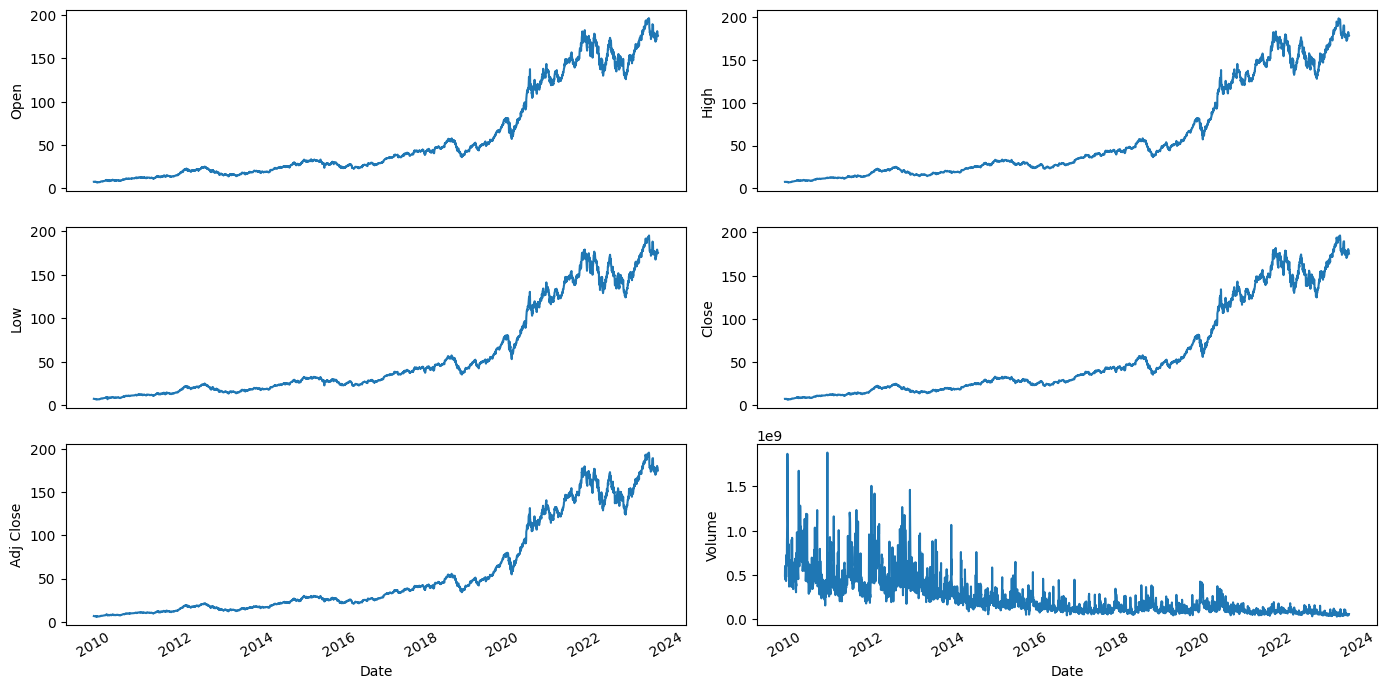

Line charts for NVDA: 



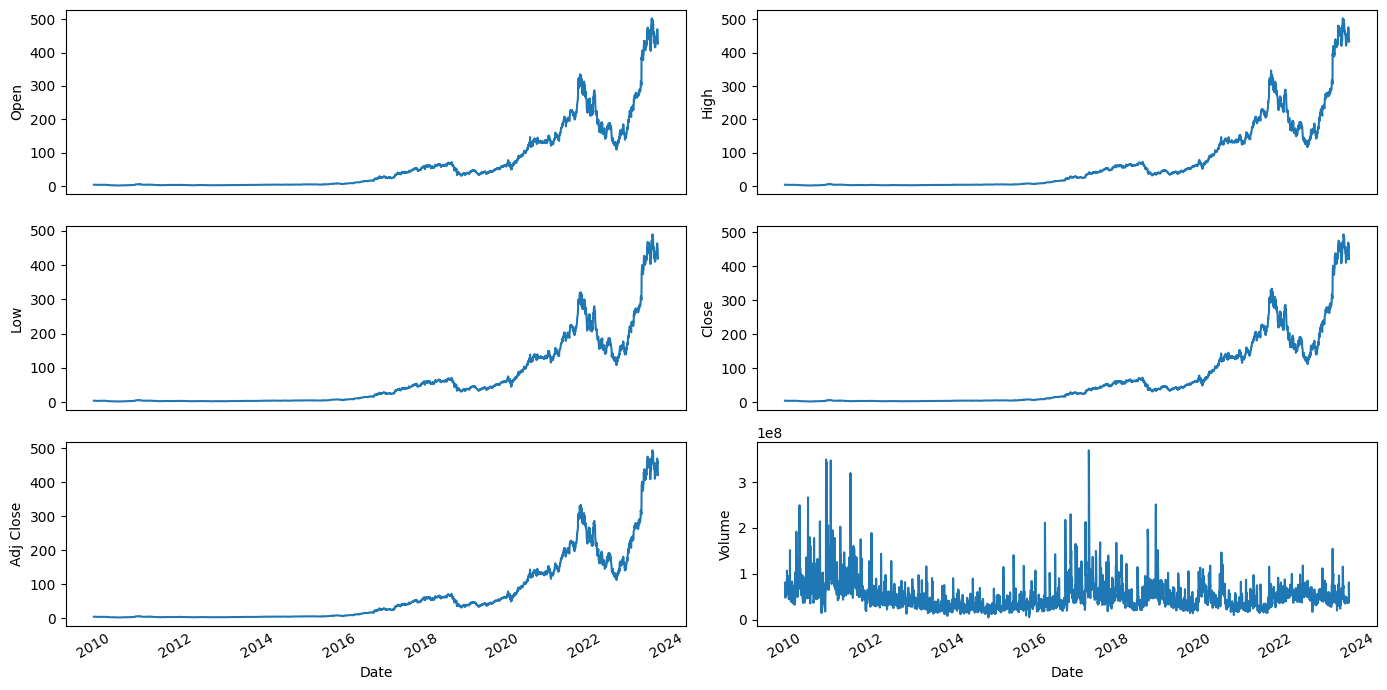

Line charts for MAR: 



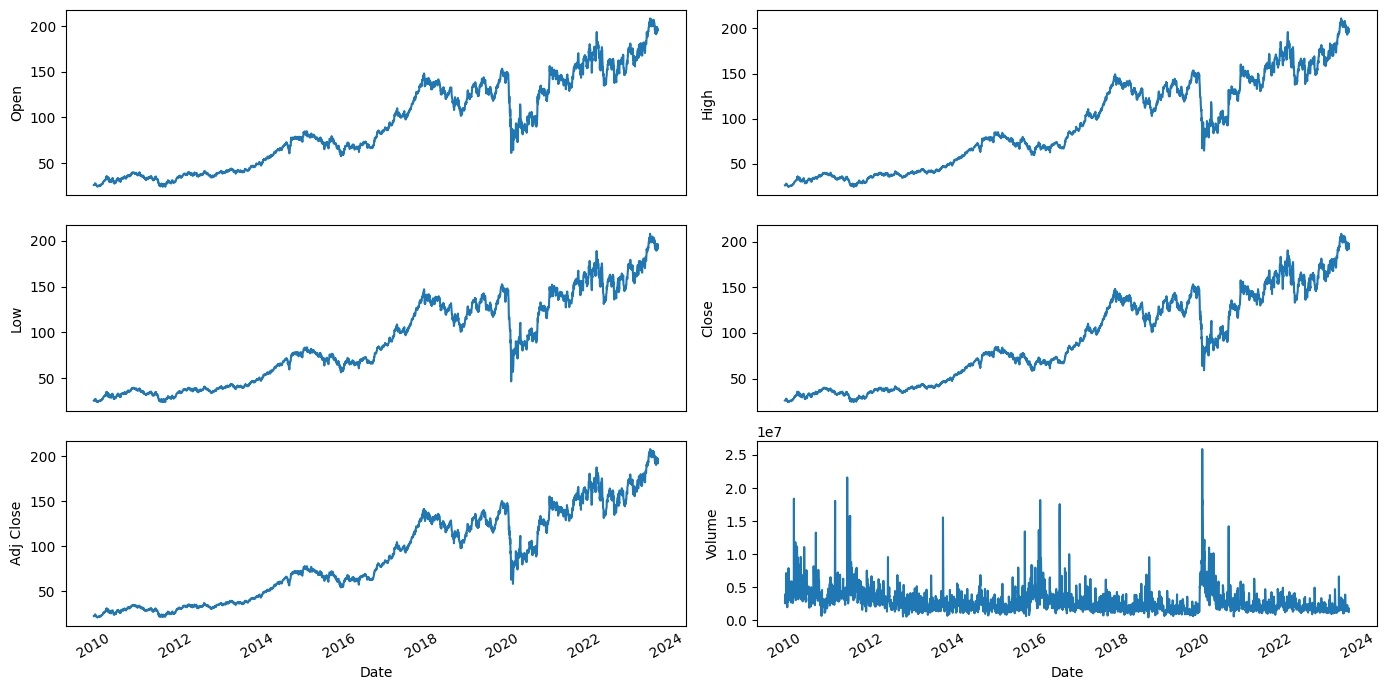

Line charts for LMT: 



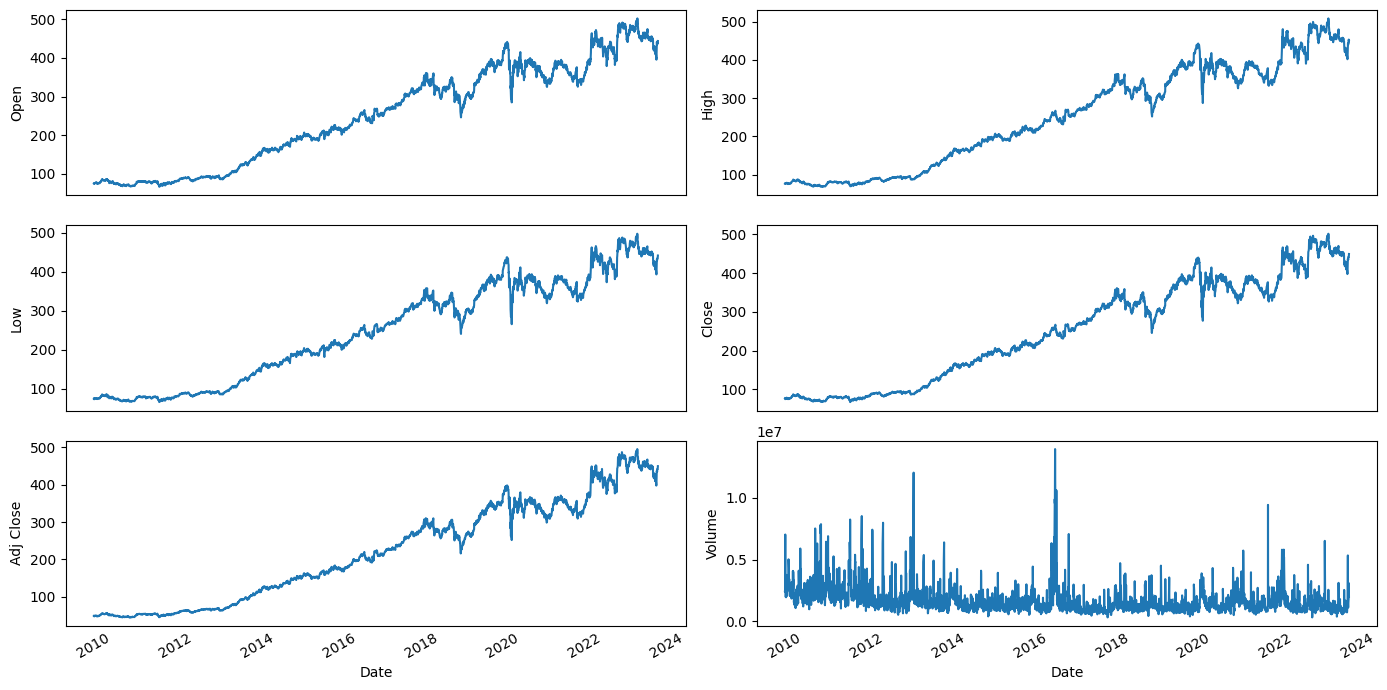

Line charts for BA: 



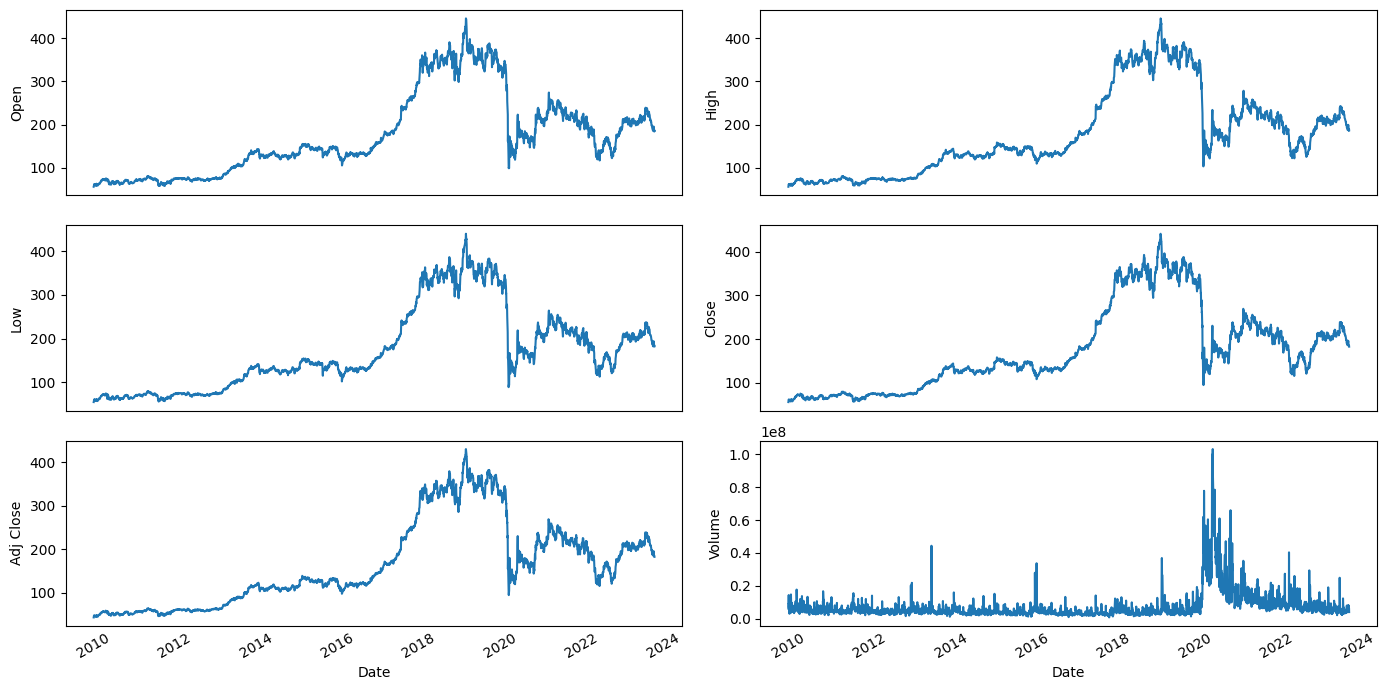

In [15]:
# Explore data: Create line charts for columns of dataset
# Define the DataFrame to plot (Will display line charts for 5 stocks separately here for ease of visualisation)
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-10-20')
nvda_df = yf.download('NVDA', start='2010-01-01', end='2023-10-20')
mar_df = yf.download('MAR', start='2010-01-01', end='2023-10-20')
lmt_df = yf.download('LMT', start='2010-01-01', end='2023-10-20')
ba_df = yf.download('BA', start='2010-01-01', end='2023-10-20')

# Function to plot line chart of every stock in stock_df (For a quick glance)
def plot_line_charts(stock_df):
    # Plot line charts
    df_plot = stock_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

print("Line charts for AAPL: \n")
plot_line_charts(aapl_df)
print("Line charts for NVDA: \n")
plot_line_charts(nvda_df)
print("Line charts for MAR: \n")
plot_line_charts(mar_df)
print("Line charts for LMT: \n")
plot_line_charts(lmt_df)
print("Line charts for BA: \n")
plot_line_charts(ba_df)

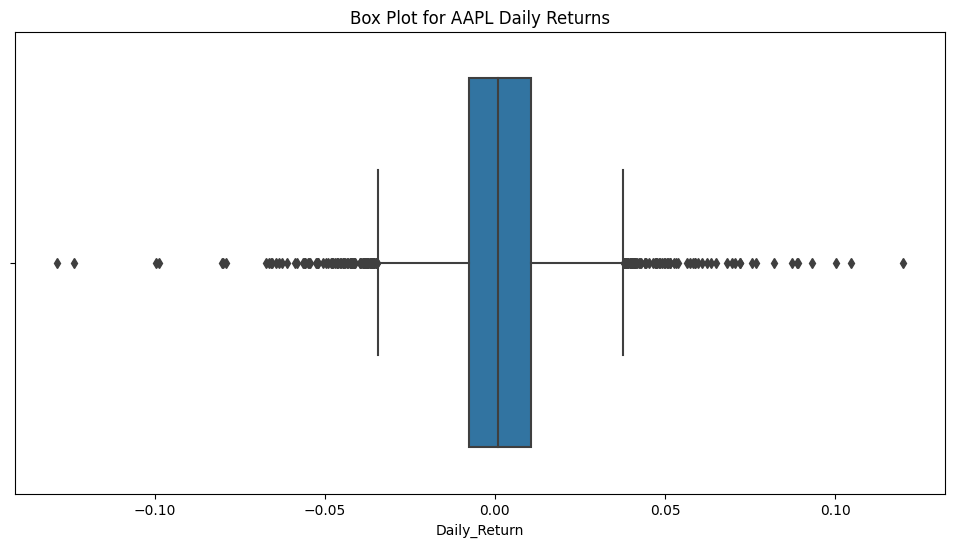

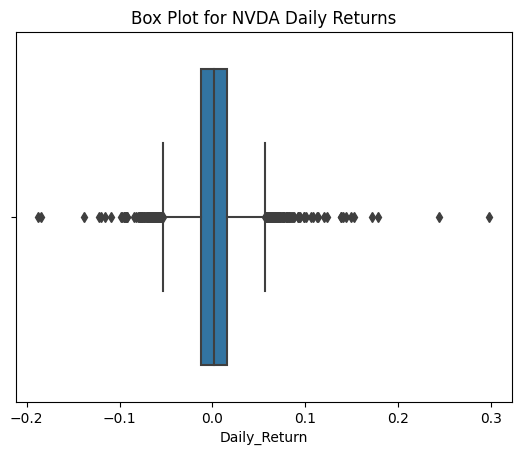

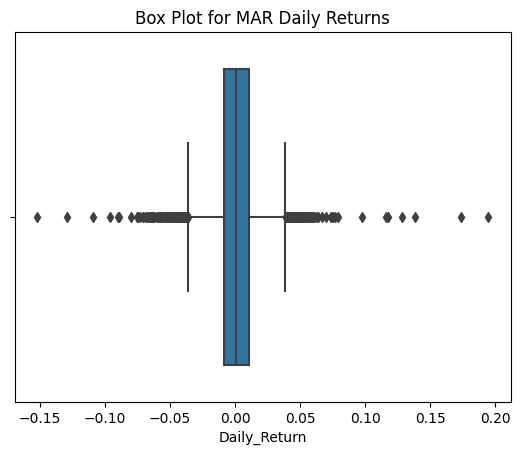

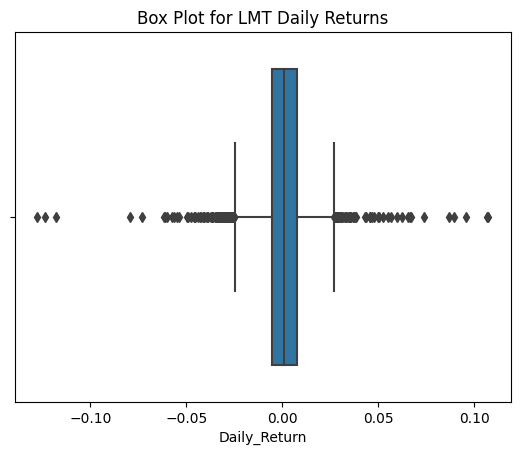

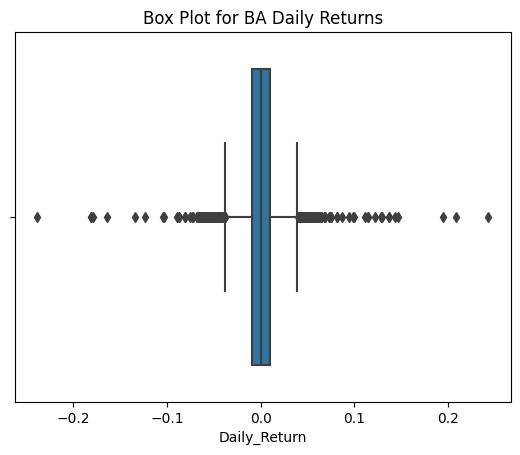

In [19]:
# Step 3: Feature Engineering
# Forecast daily returns by creating return column and analyse possible outliers using boxplot

for stock in stocks:
    stock_data[stock, 'Daily_Return'] = stock_data[stock]['Adj Close'].pct_change()
    stock_data = stock_data.sort_index(axis=1)
# print(stock_data)

# Perform data analysis to identify possible outliers
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.boxplot(x=stock_data[stock]["Daily_Return"])
    plt.title(f'Box Plot for {stock} Daily Returns')
    plt.show()
    print("\n")

In [ ]:
# Using log transformation to reduce the impact of outliers, instead of removing them
# Since we feel that outliers are meaningful and representative of actual market conditions/events
stock_data.head()

AAPL                                                        \
           Adj Close     Close Daily Returns      High       Low      Open   
Date                                                                         
2010-01-04  6.487534  7.643214           NaN  7.660714  7.585000  7.622500   
2010-01-05  6.498750  7.656429      0.001729  7.699643  7.616071  7.664286   
2010-01-06  6.395378  7.534643     -0.015906  7.686786  7.526786  7.656429   
2010-01-07  6.383556  7.520714     -0.001849  7.571429  7.466071  7.562500   
2010-01-08  6.425996  7.570714      0.006648  7.571429  7.466429  7.510714   

                              BA                           ...        MAR  \
               Volume  Adj Close      Close Daily Returns  ...        Low   
Date                                                       ...              
2010-01-04  493729600  43.777542  56.180000           NaN  ...  25.636192   
2010-01-05  601904800  45.211342  58.020000      0.032752  ...  25.796417   
2010-01-06  552160000  46.582794  59.779999      0.030334  ...  25.947220   
2010-01-07  477131200  48.468544  62.200001      0.040482  ...  26.107447   
2010-01-08  447610800  48.001007  61.599998     -0.009646  ...  26.163996   

                                    NVDA                                       \
                 Open   Volume Adj Close   Close Daily Returns   High     Low   
Date                                                                            
2010-01-04  26.022619  2860350  4.240802  4.6225           NaN  4.655  4.5275   
2010-01-05  25.984921  2627885  4.302728  4.6900      0.014602  4.740  4.6050   
2010-01-06  26.145145  2789900  4.330249  4.7200      0.006396  4.730  4.6425   
2010-01-07  26.154572  2560724  4.245388  4.6275     -0.019597  4.715  4.5925   
2010-01-08  26.182846  3961031  4.254562  4.6375      0.002161  4.670  4.5625   

                              
              Open    Volume  
Date                          
2010-01-04  4.6275  80020400  
2010-01-05  4.6050  72864800  
2010-01-06  4.6875  64916800  
2010-01-07  4.6950  54779200  
2010-01-08  4.5900  47816800  

[5 rows x 35 columns]

In [ ]:
# Step 3: Feature Engineering
# Will be incorporating indicators from chart analysis to measure price momentum




